<h1>Preguntas</h1>
<b>Bibliotecas</b>

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import geopandas as gpd
import contextily as ctx
import seaborn as sns
import numpy as np
import folium

<b>Datos Limpios</b>

In [6]:
games = pd.read_csv('Clean/games.csv')
shots = pd.read_csv('Clean/shots.csv')
players = pd.read_csv('Clean/players.csv')
teams = pd.read_csv('Clean/teams.csv')
teamstats = pd.read_csv('Clean/teamstats.csv')
leagues = pd.read_csv('Clean/leagues.csv')
appearances = pd.read_csv('Clean/appearances.csv')
teams_with_geo = pd.read_csv('Clean/teams_with_geo.csv')
positions = pd.read_csv('Clean/positions.csv')

<h2>Funciones</h2>

<b>Creacion de un campo de futbol para graficar</b>

In [10]:
def dibujar_campo(ax=None):
    if ax is None:
        ax = plt.gca()
    # Dimensiones del campo de fútbol
    campo_largo = 105
    campo_ancho = 68

    # Dibujar el campo
    ax.set_xlim(0, campo_largo)
    ax.set_ylim(0, campo_ancho)

    # Bordes del campo
    campo = patches.Rectangle([0, 0], campo_largo, campo_ancho, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(campo)

    # Línea central
    linea_central = patches.ConnectionPatch((campo_largo/2, 0), (campo_largo/2, campo_ancho), 'data', 'data', linewidth=2, edgecolor='black')
    ax.add_patch(linea_central)

    # Círculo central
    circulo_central = patches.Circle((campo_largo/2, campo_ancho/2), campo_ancho*0.1, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(circulo_central)

    # Puntos de penal
    punto_penal_izq = patches.Circle((campo_largo*0.1, campo_ancho/2), campo_ancho*0.01, linewidth=2, edgecolor='black', facecolor='black')
    punto_penal_der = patches.Circle((campo_largo*0.9, campo_ancho/2), campo_ancho*0.01, linewidth=2, edgecolor='black', facecolor='black')
    ax.add_patch(punto_penal_izq)
    ax.add_patch(punto_penal_der)

    # Áreas de penal
    area_penal_izq = patches.Rectangle([0, campo_ancho*0.2], campo_largo*0.15, campo_ancho*0.6, linewidth=2, edgecolor='black', facecolor='none')
    area_penal_der = patches.Rectangle([campo_largo*0.85, campo_ancho*0.2], campo_largo*0.15, campo_ancho*0.6, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(area_penal_izq)
    ax.add_patch(area_penal_der)

    # Áreas pequeñas
    area_pequena_izq = patches.Rectangle([0, campo_ancho*0.4], campo_largo*0.05, campo_ancho*0.2, linewidth=2, edgecolor='black', facecolor='none')
    area_pequena_der = patches.Rectangle([campo_largo*0.95, campo_ancho*0.4], campo_largo*0.05, campo_ancho*0.2, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(area_pequena_izq)
    ax.add_patch(area_pequena_der)

<b>Función para solicitar un año de la temporada</b>

In [14]:
def solicitar_temporada():
    available_seasons = games['season'].unique()
    print("Temporadas disponibles:")
    for season in available_seasons:
        print(season)
    
    while True:
        try:
            season = int(input("Ingrese el año de la temporada (ej. 2019): "))
            if season in available_seasons:
                return season
            else:
                print("Temporada no encontrada. Por favor, seleccione una temporada disponible.")
        except ValueError:
            print("Por favor, ingrese un año válido.")

<b>Función para solicitar la liga</b>

In [17]:
def solicitar_liga(temporada):
    # Filtrar juegos por la temporada seleccionada
    games_filtered_by_season = games[games['season'] == temporada]
    
    # Mostrar opciones de ligas para la temporada seleccionada
    available_leagues = games_filtered_by_season['leagueID'].unique()
    print(f"Ligas disponibles para la temporada {temporada}:")
    for idx, league_id in enumerate(available_leagues, 1):
        league_name = leagues[leagues['leagueID'] == league_id]['name'].iloc[0]
        print(f"{idx}. {league_name}")
    
    while True:
        try:
            option = int(input("Ingrese el número de la liga: "))
            league_id = available_leagues[option - 1]
            league_name = leagues[leagues['leagueID'] == league_id]['name'].iloc[0]
            return league_id, league_name  # Devolver league_name también
        except (IndexError, ValueError):
            print("Opción inválida. Por favor, ingrese un número válido.")

<b>Función para solicitar el equipo dentro de la liga y temporada seleccionadas</b>

In [20]:
def solicitar_equipo(league_id, temporada, league_name):  # Pasar league_name como argumento
    # Filtrar juegos por la liga y temporada seleccionadas para obtener los equipos
    home_teams = games[(games['leagueID'] == league_id) & (games['season'] == temporada)]['homeTeamID']
    away_teams = games[(games['leagueID'] == league_id) & (games['season'] == temporada)]['awayTeamID']
    
    # Obtener IDs únicos de equipos
    seasonal_team_ids = pd.concat([home_teams, away_teams]).unique()
    
    # Obtener nombres de equipos
    seasonal_teams = teams[teams['teamID'].isin(seasonal_team_ids)]
    
    # Mostrar los equipos disponibles
    print(f"Equipos disponibles para la liga {league_name} en la temporada {temporada}:")
    seasonal_team_options = list(seasonal_teams['name'])
    for idx, team in enumerate(seasonal_team_options, 1):
        print(f"{idx}. {team}")
    
    while True:
        try:
            option = int(input("Ingrese el número del equipo: "))
            team_name = seasonal_team_options[option - 1]
            team_id = seasonal_teams[seasonal_teams['name'] == team_name]['teamID'].iloc[0]
            return team_id, team_name
        except (IndexError, ValueError):
            print("Opción inválida. Por favor, ingrese un número válido.")

<b>Función para solicitar temporada, liga y equipo</b>

In [23]:
def solicitar_temporada_liga_equipo():
    temporada = solicitar_temporada()
    print(f"Temporada seleccionada: {temporada}")
    
    league_id, league_name = solicitar_liga(temporada)
    print(f"Liga seleccionada: {league_name} (ID: {league_id})")
    
    # Pasar league_name como argumento a solicitar_equipo
    team_id, team_name = solicitar_equipo(league_id, temporada, league_name)
    print(f"Equipo seleccionado: {team_name} (ID: {team_id})")
    
    return temporada, league_id, league_name, team_id, team_name

<b>Función para filtrar apariciones por liga, temporada y equipo seleccionados</b>

In [26]:
def filtrar_apariciones(league_id, season, team_id):
    # Filtrar juegos por la liga, temporada y equipo seleccionados
    games_filtered = games[(games['leagueID'] == league_id) & 
                           (games['season'] == season) & 
                           ((games['homeTeamID'] == team_id) | (games['awayTeamID'] == team_id))]
    
    # Obtener IDs de los juegos filtrados
    game_ids = games_filtered['gameID'].unique()
    
    # Filtrar apariciones por los IDs de juego obtenidos
    appearances_filtered = appearances[appearances['gameID'].isin(game_ids)]
        
    # Devolver el DataFrame filtrado
    return appearances_filtered  

<h2>Pregunta 1:</h2>
<h4>Como es la distribución de faltas según equipo por posición por temporada.</h4> 

Temporadas disponibles:
2015
2016
2014
2017
2018
2019
2020


Ingrese el año de la temporada (ej. 2019):  2020


Ligas disponibles para la temporada 2020:
1. Ligue 1
2. Premier League
3. Serie A
4. La Liga
5. Bundesliga


Ingrese el número de la liga:  4


Equipos disponibles para la liga La Liga en la temporada 2020:
1. Sevilla
2. Real Sociedad
3. Getafe
4. Atletico Madrid
5. Valencia
6. Athletic Club
7. Barcelona
8. Real Madrid
9. Levante
10. Celta Vigo
11. Villarreal
12. Granada
13. Eibar
14. Elche
15. Real Betis
16. Osasuna
17. Alaves
18. Real Valladolid
19. SD Huesca
20. Cadiz


Ingrese el número del equipo:  4


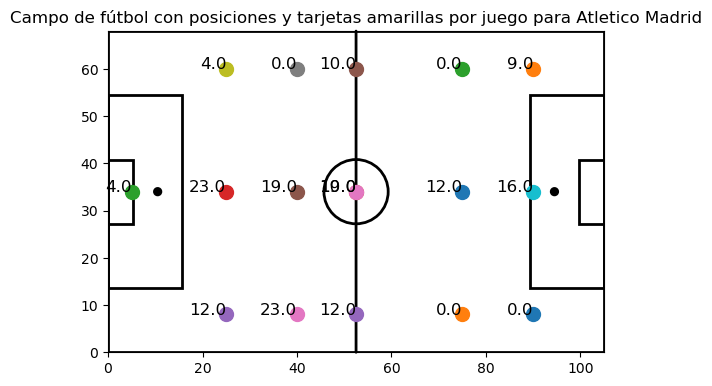

In [33]:
#Solicitud de temporada, liga y equipo
season = solicitar_temporada()
    
league_id, league_name = solicitar_liga(season)
    
# Pasar league_name como argumento a solicitar_equipo
team_id, team_name = solicitar_equipo(league_id, season, league_name)
    
appearances_filtered = filtrar_apariciones(league_id, season, team_id)
    
# Agrupando y sumando las tarjetas amarillas por posición
yellow = appearances_filtered.groupby('position')['yellowCard'].sum().reset_index()
    
# Contando el número de juegos por posición
count = appearances_filtered.groupby('position').size().reset_index(name='games_count')
    
# Fusionando los resultados de las tarjetas amarillas y el conteo de juegos por posición
result = yellow.merge(count, on='position', how='left')
    
# Convertir yellowCard a entero para evitar decimales
result['yellowCard'] = result['yellowCard'].astype(int)
    
# Calcular tarjetas amarillas por juego
result['yellowCardsPerGame'] = result['yellowCard'] * 100 / result['games_count']
    
# Renombrar columna de posiciones 
positions.rename(columns={'position': 'position'}, inplace=True)
    
# Fusionar con datos de posiciones 
end = pd.merge(result, positions, on='position', how='inner')
    
# Redondear las columnas que deseas limitar a ciertos decimales
end['yellowCardsPerGame'] = end['yellowCardsPerGame'].round(0)
    
# Dimensiones del campo de fútbol estándar 
campo_largo = 105
campo_ancho = 68
    
# Configurar el gráfico
fig, ax = plt.subplots()
    
# Llamar a la función para dibujar el campo de fútbol 
dibujar_campo(ax)

for index, row in end.iterrows():
        x = row['X']
        y = row['Y']
        yellow_cards_per_game = row['yellowCardsPerGame']  # Obtener el número de yellowCardsPerGame
        label = f"{yellow_cards_per_game}\nProm. Amarillas/Juego: {yellow_cards_per_game:.2f}"  # Construir la etiqueta
        ax.plot(x, y, 'o', markersize=10, label=label)
        ax.text(x, y, yellow_cards_per_game, fontsize=12, ha='right')
        
# Ajustar límites y aspecto del gráfico
plt.title(f'Campo de fútbol con posiciones y tarjetas amarillas por juego para {team_name}')
plt.xlim(0, campo_largo)
plt.ylim(0, campo_ancho)
plt.gca().set_aspect('equal', adjustable='box')
    
plt.show()

<h2>Pregunta 2:</h2>
<h4>Donde anota el mejor jugador de una temporada y año especifico?</h4> 

Temporadas disponibles:
2015
2016
2014
2017
2018
2019
2020


Ingrese el año de la temporada (ej. 2019):  2020


Ligas disponibles para la temporada 2020:
1. Ligue 1
2. Premier League
3. Serie A
4. La Liga
5. Bundesliga


Ingrese el número de la liga:  4


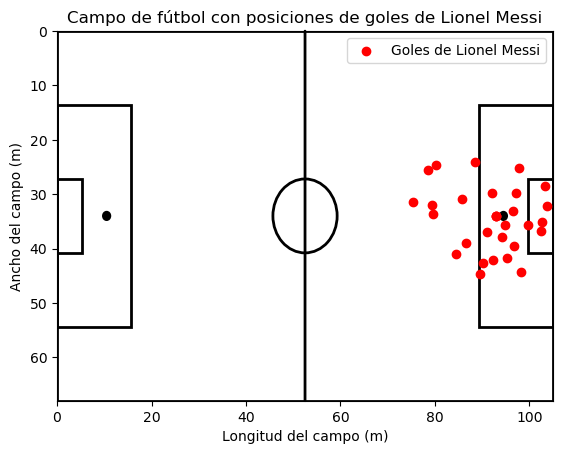

In [199]:
# Solicitar temporada y liga al usuario    
season = solicitar_temporada()
league_id, league_name = solicitar_liga(season)
    
# Filtrar juegos de la liga y temporada especificadas por el usuario
games_filtered = pd.merge(games[games['season'] == season], leagues[leagues['name'] == league_name], on='leagueID', how='inner')

# Filtrar tiros por el nombre de la liga y temporada seleccionadas
shots_filtered = pd.merge(shots, games_filtered[['gameID']], on='gameID', how='inner')

# 1. Encontrar al mayor goleador
goals = shots_filtered[shots_filtered['shotResult'] == 'Goal']
goals_count = goals.groupby('shooterID').size()
max_scorer = goals_count.idxmax()

# 2. Filtrar los datos del jugador con más goles
players = players.rename(columns={'playerID': 'shooterID'}) 
player_name = players.loc[players['shooterID'] == max_scorer, 'name'].iloc[0]
player_shots = shots_filtered[(shots_filtered['shooterID'] == max_scorer) & (shots_filtered['shotResult'] == 'Goal')]
    
# Dimensiones del campo de fútbol estándar (en metros)
campo_largo = 105
campo_ancho = 68

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Dibujar el campo de fútbol
dibujar_campo(ax)

# Convertir las coordenadas de posiciónX y posiciónY a las dimensiones del campo
player_shots = player_shots.assign(
    x = player_shots['positionX'] * campo_largo,
    y = player_shots['positionY'] * campo_ancho
)

# Dibujar marcadores de los goles
ax.scatter(player_shots['x'], player_shots['y'], color='red', label='Goles de ' + player_name)

# Añadir detalles al gráfico
plt.title(f'Campo de fútbol con posiciones de goles de {player_name}')
plt.xlabel('Longitud del campo (m)')
plt.ylabel('Ancho del campo (m)')
plt.xlim(0, campo_largo)
plt.ylim(0, campo_ancho)
plt.gca().invert_yaxis()  # Invertir el eje y para que el origen esté en la esquina inferior izquierda
plt.legend()

# Mostrar el gráfico
plt.show()


<h2>Pregunta 3:</h2>
<h4>Crear un mapa, según ciudades donde mostrar cuales ganaron mas torneos.</h4> 

In [35]:
# Calcular estadísticas básicas por liga, equipo y temporada
seasons = teamstats.groupby(['teamID', 'season']).agg({
    'gameID': 'count',
    'goals': 'sum'
}).rename(columns={'gameID': 'gamesPlayed', 'goals': 'totalGoals'})

# Calcular victorias y empates
wins = teamstats[teamstats['result'] == "W"].groupby(['teamID', 'season']).size()
draws = teamstats[teamstats['result'] == "D"].groupby(['teamID', 'season']).size()

# Añadir columnas de victorias y empates al DataFrame performance
seasons['Wins'] = wins
seasons['Draws'] = draws

# Reemplazar NaN con 0
seasons = seasons.fillna(0)

# Calcular puntos obtenidos
seasons['Points'] = seasons['Wins'] * 3 + seasons['Draws']

# Reiniciar el índice para una mejor visualización
seasons.reset_index(inplace=True)

# Obtener la información de la liga del DataFrame games
league_info_home = games[['homeTeamID', 'season', 'leagueID']].drop_duplicates().rename(columns={'homeTeamID': 'teamID'})
league_info_away = games[['awayTeamID', 'season', 'leagueID']].drop_duplicates().rename(columns={'awayTeamID': 'teamID'})
league_info = pd.concat([league_info_home, league_info_away]).drop_duplicates()

# Unir para obtener los nombres de los equipos y las ligas
seasons = seasons.merge(league_info, on=['teamID', 'season'], how='left')
seasons = seasons.merge(teams_with_geo[['teamID', 'name', 'city', 'longitude', 'latitude']], on='teamID', how='left')
seasons = seasons.merge(leagues[['leagueID', 'name']].rename(columns={'name': 'League'}), on='leagueID', how='left')

# Calcular partidos perdidos
seasons['Losses'] = seasons['gamesPlayed'] - (seasons['Wins'] + seasons['Draws'])

# Reorganizar columnas para una mejor visualización
seasons = seasons[['leagueID', 'League', 'teamID', 'name', 'season', 'gamesPlayed', 'totalGoals', 'Wins', 'Draws', 'Losses', 'Points', 'longitude', 'latitude', 'city' ]]

# Determinar el equipo ganador por liga y temporada
winners = seasons.sort_values(by=['Points', 'totalGoals'], ascending=[False, False]).groupby(['leagueID', 'season']).first().reset_index()

# Crear un mapa base utilizando Folium
m = folium.Map(location=[winners['latitude'].mean(), winners['longitude'].mean()], zoom_start=4)

# Añadir los marcadores de las ciudades ganadoras
for index, row in winners.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['city']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Guardar el mapa como HTML
m.save('ganadores_torneos.html')
m

<h2>Pregunta 4:</h2>
<h4>Crear un mapa, en que se juegan mas partidos.</h4> 

In [58]:
# Renombrar columna de posiciones 
games.rename(columns={'homeTeamID': 'teamID'}, inplace=True)

# Realizamos el merge entre merged_data y teams para obtener la ciudad de cada equipo en cada partido
merged_data = pd.merge(games, teams_with_geo[['teamID', 'city', 'longitude', 'latitude']], on='teamID', how='left')

# Contamos el número de partidos celebrados en cada ciudad
city_match_count = merged_data['city'].value_counts().reset_index()
city_match_count.columns = ['city', 'num_matches']

# Añadimos las coordenadas de latitud y longitud a city_match_count
city_coords = merged_data[['teamID', 'city', 'latitude', 'longitude', 'leagueID']].drop_duplicates()

city_match_count = pd.merge(city_match_count, city_coords[['teamID', 'city', 'latitude', 'longitude', 'leagueID' ]], on='city', how='left')

# Guardar en un archivo CSV para usar en tableau, me quedo con uno
extra = city_match_count.drop_duplicates(subset='city')

city_match_count.to_csv('Tableau/games_played.csv', index=False)

# Crear un mapa de Folium centrado en un punto medio de las ciudades
map = folium.Map(location=[city_match_count['latitude'].mean(), city_match_count['longitude'].mean()], zoom_start=4)

# Mostrar solo una marca por ciudad
visited_cities = set()
for index, row in city_match_count.iterrows():
    city = row['city']
    if city not in visited_cities:
        popup_text = f"{city}: {row['num_matches']} partidos"
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=16 * (row['num_matches'] / city_match_count['num_matches'].max()),  # Ajustar el tamaño del círculo
            popup=popup_text,
            color='black',
            fill=True,
            fill_color='crimson'
        ).add_to(map)
        visited_cities.add(city)

# Mostrar el mapa
map 

<h2>Pregunta 5:</h2>
<h4>Como es la evolución de fouls a lo largo del tiempo en distintas ligas. Histograma con filtros</h4> 

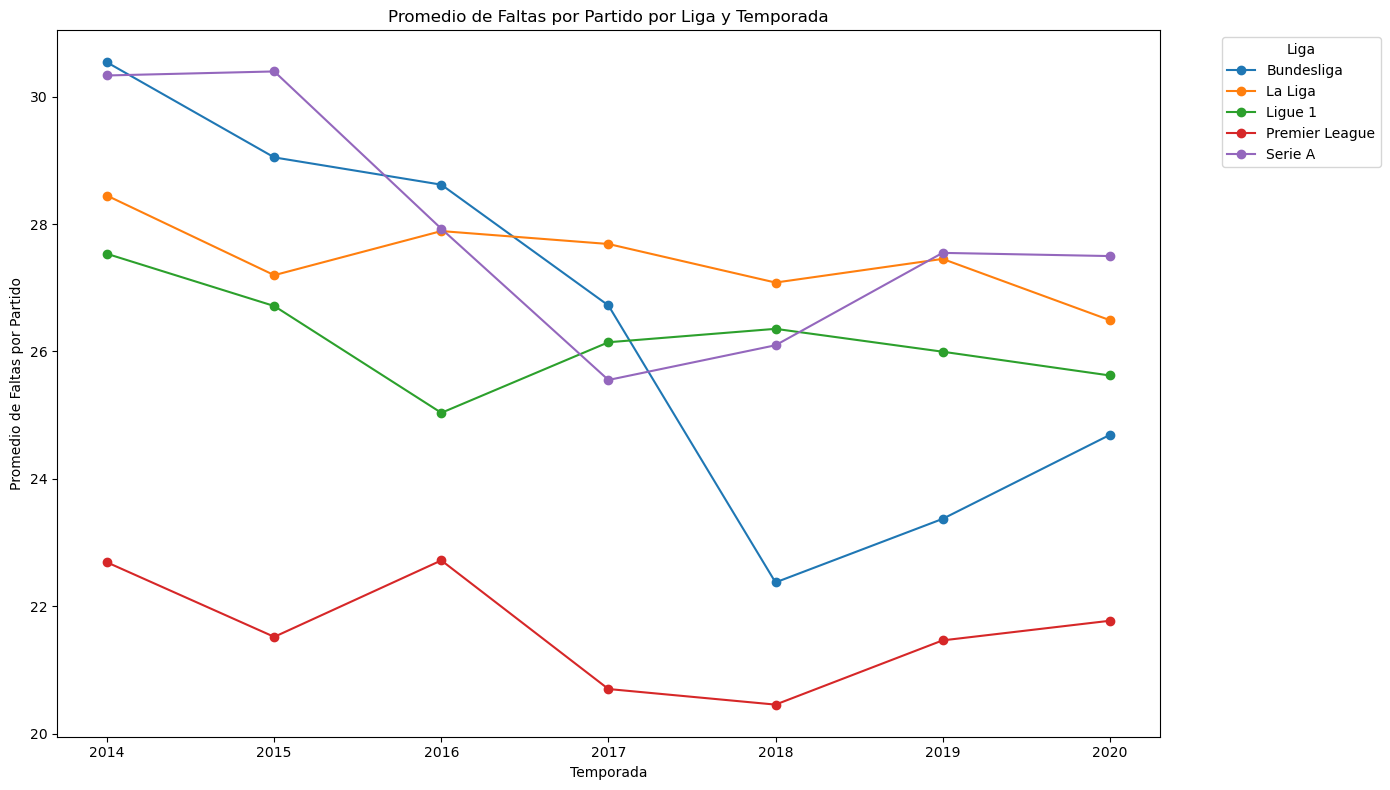

In [61]:
# Realizar un merge de los datos en base a 'gameID'
merged_data = pd.merge(teamstats[['gameID', 'teamID', 'season', 'fouls']],
                       games[['gameID', 'leagueID']],
                       on='gameID')

# Agrupar por 'leagueID' y 'season'
grouped_data = merged_data.groupby(['leagueID', 'season'])

# Calcular el número total de faltas y el número de partidos jugados
fouls_per_league_season = grouped_data['fouls'].sum()
games_per_league_season = grouped_data['gameID'].nunique()

# Calcular el promedio de faltas por partido
fouls_per_game = fouls_per_league_season / games_per_league_season

# Convertir a DataFrame para hacer merge con leagues
fouls_per_game_df = fouls_per_game.reset_index()
fouls_per_game_df.columns = ['leagueID', 'season', 'fouls_per_game']  # Cambiar nombre de columna

# Hacer merge con la tabla leagues para obtener los nombres de las ligas
result = pd.merge(fouls_per_game_df, leagues[['leagueID', 'name']], on='leagueID')

# Guardar en un archivo CSV
result.to_csv('Tableau/fouls_per_league.csv', index=False)

# Configurar la gráfica
plt.figure(figsize=(14, 8))

# Graficar los resultados
for name, group in result.groupby('name'):
    plt.plot(group['season'], group['fouls_per_game'], marker='o', label=name)

# Añadir título y etiquetas
plt.title('Promedio de Faltas por Partido por Liga y Temporada')
plt.xlabel('Temporada')
plt.ylabel('Promedio de Faltas por Partido')
plt.legend(title='Liga', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

<h2>Pregunta 6:</h2>
<h4>Quienes son los jugadores que obtienen mejores resultados al participacipar en jugadas de pelota quieta, corners y tiros libre</h4> 

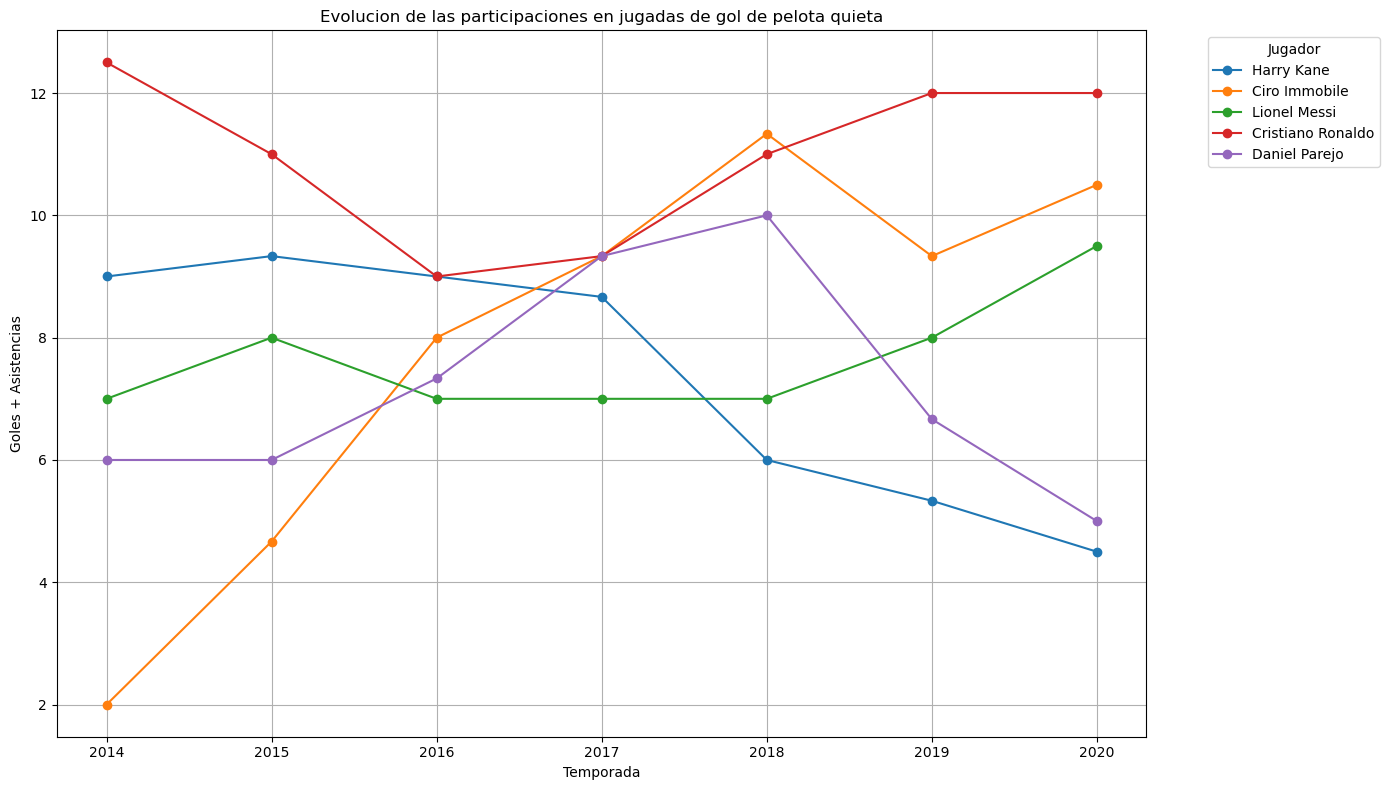

In [64]:

# Filtrar los tiros que son goles y de situaciones específicas
goals = shots[((shots['situation'] == 'FromCorner') | 
               (shots['situation'] == 'SetPiece') |
               (shots['situation'] == 'Penalty') | 
               (shots['situation'] == 'DirectFreeKick')) & 
              (shots['shotResult'] == 'Goal')]

# Eliminar duplicados
goals = goals.drop_duplicates()

# Ordenar y seleccionar columnas relevantes para goles y asistencias
score = goals[['gameID', 'shooterID', 'minute']].rename(columns={'shooterID': 'playerID'})
assist = goals[['gameID', 'assisterID', 'minute']].rename(columns={'assisterID': 'playerID'})

# Combinar los DataFrames de goles y asistencias
total = pd.concat([score, assist])

# Añadir información de la temporada
total = total.merge(games[['gameID', 'season']], on='gameID')

# Contar el número total de contribuciones (goles y asistencias) por jugador y por temporada
total_contributions = total.groupby(['playerID', 'season']).size().reset_index(name='total_contributions')

# Guardar en un archivo CSV
total_contributions.to_csv('Tableau/total_contributions.csv', index=False)

# Seleccionar los 5 mejores jugadores con más contribuciones totales
top_players = total_contributions.groupby('playerID')['total_contributions'].sum().reset_index()
top_players = top_players.nlargest(6, 'total_contributions')

# Filtrar las contribuciones de los 10 mejores jugadores
top_player_contributions = total_contributions[total_contributions['playerID'].isin(top_players['playerID'])]

# Añadir nombres de jugadores
top_player_contributions = top_player_contributions.merge(players[['playerID', 'name']], on='playerID')

# Aplicar suavizado de media móvil
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1, center=True).mean()

# Graficar la evolución de las contribuciones por año para cada uno de los 10 mejores jugadores
plt.figure(figsize=(14, 8))
for player in top_player_contributions['name'].unique():
    player_data = top_player_contributions[top_player_contributions['name'] == player]
    smoothed_data = moving_average(player_data.set_index('season')['total_contributions'], window_size=3)
    plt.plot(smoothed_data.index, smoothed_data.values, marker='o', label=player)

plt.xlabel('Temporada')
plt.ylabel('Goles + Asistencias')
plt.title('Evolucion de las participaciones en jugadas de gol de pelota quieta')
plt.legend(title='Jugador', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


<h2>Pregunta 7:</h2>
<h4>¿Qué equipos de cada liga obtienen mas puntos de visitante?</h4> 

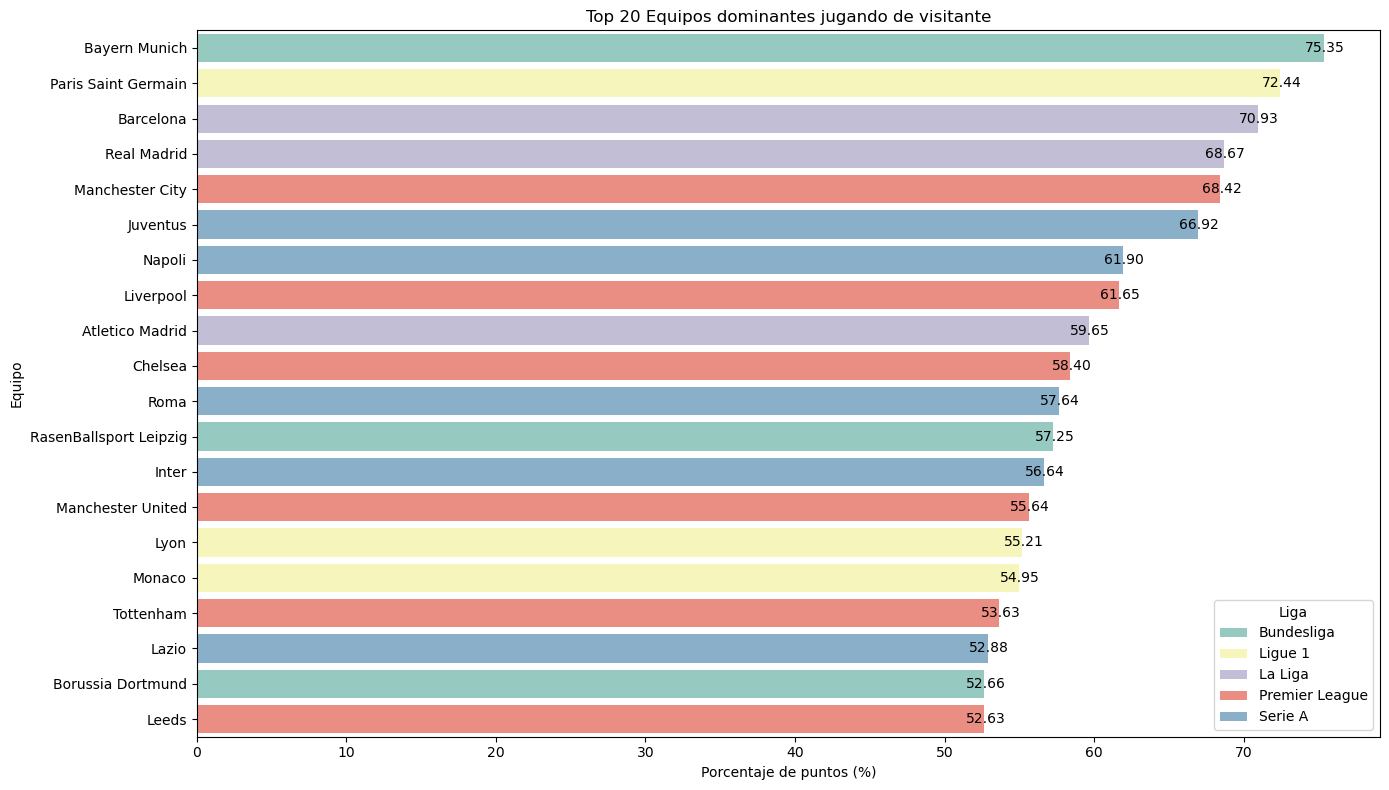

In [67]:
# Filtrar partidos de visitante, renombrar para trabajar más cómodo
away_games = games[['gameID', 'leagueID', 'season', 'date', 'awayTeamID', 'awayGoals', 'homeGoals']].rename(columns={'awayTeamID': 'teamID', 'awayGoals': 'goals', 'homeGoals': 'opponentGoals'})

# Calcular estadísticas de rendimiento de visitante por liga
performance = away_games.groupby(['leagueID', 'teamID']).agg({
    'gameID': 'count',
    'goals': 'sum'
}).rename(columns={'gameID': 'awayGames', 'goals': 'awayGoals'})

# Calcular victorias y empates
away_wins = away_games[away_games['goals'] > away_games['opponentGoals']].groupby(['leagueID', 'teamID']).size()
away_draws = away_games[away_games['goals'] == away_games['opponentGoals']].groupby(['leagueID', 'teamID']).size()

# Añadir columnas de victorias y empates
performance['awayWins'] = away_wins
performance['awayDraws'] = away_draws

# Reemplazar NaN con 0
performance = performance.fillna(0)

# Calcular puntos obtenidos de visitante
performance['awayPoints'] = performance['awayWins'] * 3 + performance['awayDraws']

# Calcular la métrica combinada de rendimiento
performance['performanceMetric'] = (performance['awayPoints'] / (3 * performance['awayGames'])) * 100

# Ordenar por la métrica de rendimiento dentro de cada liga
best_away_teams = performance.sort_values(by=['leagueID', 'performanceMetric'], ascending=[True, False]).reset_index()

# Unir con los nombres de las ligas y equipos
best_away_teams_by_league = best_away_teams.merge(leagues[['leagueID', 'name']], on='leagueID')
best_away_teams_by_league = best_away_teams_by_league.merge(teams[['teamID', 'name']], on='teamID')

# Seleccionar los 20 mejores equipos visitantes
top_20_away_teams = best_away_teams_by_league.nlargest(20, 'performanceMetric')

# Guardar en un archivo CSV
best_away_teams_by_league.to_csv('Tableau/best_away_teams_by_league.csv', index=False)

# Ajustar el tamaño de la figura
plt.figure(figsize=(14, 8))

# Crear gráfico de barras con Seaborn, usando el color según la liga
barplot = sns.barplot(data=top_20_away_teams, y='name_y', x='performanceMetric', hue='name_x', palette='Set3', dodge=False)

# Personalizar el gráfico
plt.title('Top 20 Equipos dominantes jugando de visitante')
plt.ylabel('Equipo')
plt.xlabel('Porcentaje de puntos (%)')
plt.legend(title='Liga')

# Añadir los números al final de cada barra, asegurando valores finitos
for p in barplot.patches:
    width = p.get_width()  # Obtener el ancho de la barra
    if np.isfinite(width):  # Verificar si el valor es finito
        plt.text(width + 0.1,  # Posición X de la anotación
                 p.get_y() + p.get_height() / 2,  # Posición Y de la anotación
                 '{:.2f}'.format(width),  # Texto de la anotación
                 ha='center', va='center')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

<h2>Pregunta 8:</h2>
<h4>Qué equipos por temporada en cada liga han generado mas situaciones de gol?</h4> 

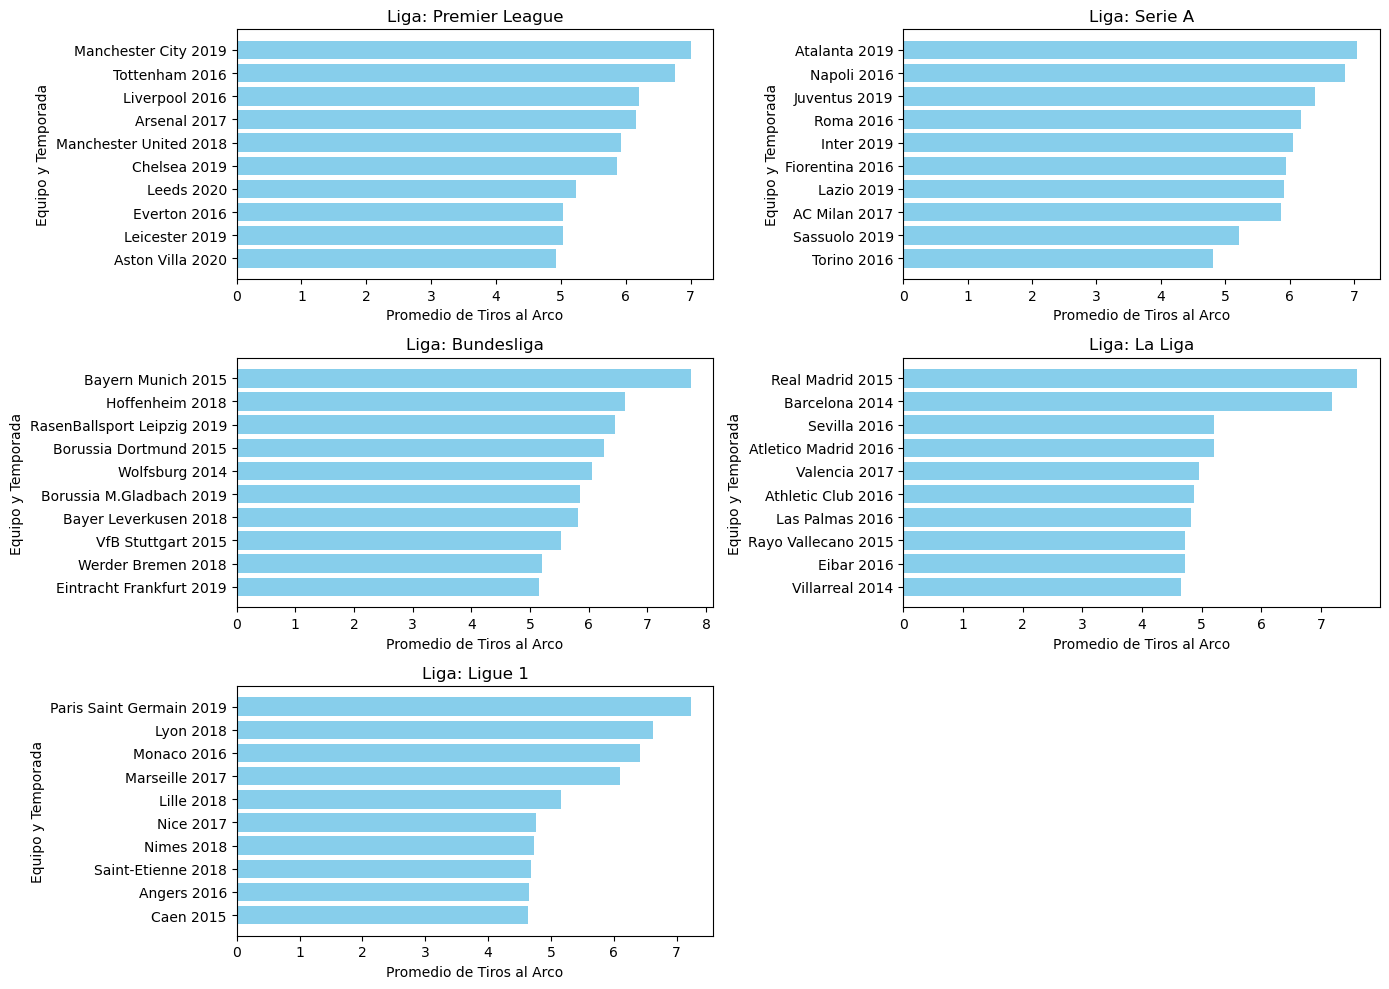

In [69]:
# Unir teamstats con teams para obtener los nombres de los equipos
teamstats_teams = teamstats.merge(teams, on='teamID')

# Unir teamstats_teams con games para obtener la liga
teamstats_games = teamstats_teams.merge(games[['gameID', 'leagueID']], on='gameID')

# Calcular el promedio de tiros al arco por equipo y liga
shot_on_target_avg = teamstats_games.groupby(['leagueID', 'teamID', 'season', 'name'])['shotsOnTarget'].mean().reset_index()

# Obtener los nombres de las ligas y renombrar columnas
shot_on_target_avg = shot_on_target_avg.merge(leagues[['leagueID', 'name']], on='leagueID')
shot_on_target_avg = shot_on_target_avg.rename(columns={'name_x': 'team_name', 'name_y': 'league_name'})

# Filtrar solo el mejor año por equipo
shot_on_target_best = shot_on_target_avg.loc[shot_on_target_avg.groupby('teamID')['shotsOnTarget'].idxmax()]

# Ordenar por liga y por el promedio de tiros al arco en orden descendente dentro de cada liga
shot_on_target_best = shot_on_target_best.sort_values(by=['leagueID', 'shotsOnTarget'], ascending=[True, False])

# Guardar en un archivo CSV
shot_on_target_best.to_csv('Tableau/shot_on_target_best.csv', index=False)

# Graficar los equipos con los promedios más altos de tiros al arco por cada liga
plt.figure(figsize=(14, 10))
for i, (leagueID, group) in enumerate(shot_on_target_best.groupby('leagueID')):
    league_name = group['league_name'].iloc[0]
    ax = plt.subplot(3, 2, i+1)
    top_teams = group[['team_name', 'season', 'shotsOnTarget']].head(10)
    ax.barh(top_teams['team_name'] + ' ' + top_teams['season'].astype(str), top_teams['shotsOnTarget'], color='skyblue')
    ax.set_title(f"Liga: {league_name}")
    ax.set_xlabel('Promedio de Tiros al Arco')
    ax.set_ylabel('Equipo y Temporada')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()
